# Project Overview: OpenAI APIs: Vertical Prediction

## Purpose

The purpose of this project is to analyze and evaluate the performance of different prompt and system messages in predicting the vertical categories of videos based on their titles. By comparing various methods, we aim to identify the most accurate nethods and understand the reasons behind incorrect predictions.

## Step-by-Step Analysis

###  Load the Data

We start by loading the comparison results of various methods into pandas DataFrames.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ast

# Load all the final comparison files
file_paths = [
"output/results/assistant_two_shot_final_comparison.csv",
"output/results/assistant_zero_shot_final_comparison.csv",
"output/results/media_anl_step_by_step_final_comparison.csv",
"output/results/data_sc_step_by_step_final_comparison.csv",
"output/results/data_sc_simple_final_comparison.csv",
"output/results/content_str_step_by_step_final_comparison.csv",
"output/results/reference_prompt_final_comparison.csv",
"output/results/simple_final_comparison.csv",
"output/results/classifier_one_shot_final_comparison.csv",
"output/results/classifier_two_shot_final_comparison.csv",
"output/results/classifier_zero_shot_final_comparison.csv",
"output/results/assistant_one_shot_final_comparison.csv"
]

dataframes = [pd.read_csv(file_path) for file_path in file_paths]


### Calculate overall accuracy for each file

In [2]:
overall_accuracies = []
for df in dataframes:
    accuracy = df['match'].mean()
    overall_accuracies.append(accuracy)

# Create a summary dataframe for overall accuracy
methods = [
    'assistant_two_shot','assistant_zero_shot','media_anl_step_by_step',
    'data_sc_step_by_step','data_sc_simple','content_str_step_by_step','reference_prompt',
    'simple','classifier_one_shot','classifier_two_shot', 'classifier_zero_shot','assistant_one_shot'
]

overall_accuracy_df = pd.DataFrame({
    'method': methods,
    'overall_accuracy': overall_accuracies
})

overall_accuracy_df


,method,overall_accuracy
0,assistant_two_shot,0.691275
1,assistant_zero_shot,0.771812
2,media_anl_step_by_step,0.765101
3,data_sc_step_by_step,0.778523
4,data_sc_simple,0.771812
5,content_str_step_by_step,0.771812
6,reference_prompt,0.744966
7,simple,0.765101
8,classifier_one_shot,0.744966
9,classifier_two_shot,0.758389


### Plot overall accuracy for each method

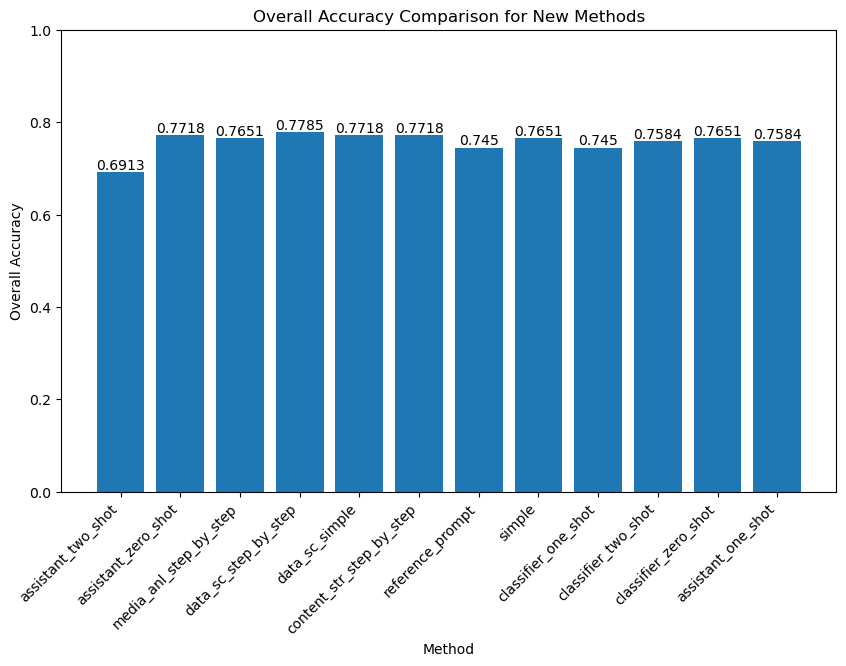

In [3]:
plt.figure(figsize=(10, 6))
bars = plt.bar(overall_accuracy_df['method'], overall_accuracy_df['overall_accuracy'])

# Display the value on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.xlabel('Method')
plt.ylabel('Overall Accuracy')
plt.title('Overall Accuracy Comparison for New Methods')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.show()

#### 
According to results, data_sc_step_by_step method has the highest overall accuracy at 0.7785. But we can clearly say that, the results are very close to each other.

#### Highest Accuracy:

The data_sc_step_by_step method has the highest overall accuracy at 0.7785. This indicates that this method is the most effective among the ones compared, in predicting the correct vertical categories for the video titles.

#### High-Performing Methods:

Several methods, including assistant_zero_shot, data_sc_simple, and content_str_step_by_step, all have very similar accuracies of 0.7718.
The media_anl_step_by_step, simple, and classifier_zero_shot methods also have relatively high accuracies, each scoring 0.7651.

#### Moderate Accuracy:

The reference_prompt and classifier_one_shot methods both have a moderate accuracy of 0.7450.
The classifier_two_shot and assistant_one_shot methods have slightly lower but still moderate accuracies of 0.7584.

#### Lowest Accuracy:

The assistant_two_shot method has the lowest overall accuracy at 0.6913, suggesting that this method may not be as effective as the others in predicting the correct vertical categories for video titles.

In [4]:
file_paths = {
    'assistant_two_shot': "output/results/assistant_two_shot_final_comparison.csv",
    'assistant_zero_shot':"output/results/assistant_zero_shot_final_comparison.csv" ,
    'media_anl_step_by_step':"output/results/media_anl_step_by_step_final_comparison.csv",
    'data_sc_step_by_step': "output/results/data_sc_step_by_step_final_comparison.csv",
    'data_sc_simple': "output/results/data_sc_simple_final_comparison.csv",
    'content_str_step_by_step': "output/results/content_str_step_by_step_final_comparison.csv" ,
    'reference_prompt': "output/results/reference_prompt_final_comparison.csv",
    'simple': "output/results/simple_final_comparison.csv",
    'classifier_one_shot': "output/results/classifier_one_shot_final_comparison.csv",
    'classifier_two_shot': "output/results/classifier_two_shot_final_comparison.csv", 
    'classifier_zero_shot': "output/results/classifier_zero_shot_final_comparison.csv",
    'assistant_one_shot': "output/results/assistant_one_shot_final_comparison.csv"
}

methods = list(file_paths.keys())

### Define Functions

In [5]:
def load_data(method):
    file_path = file_paths[method]
    df = pd.read_csv(file_path)
    return df

def analyze_incorrect_predictions(file_paths, methods):
    dataframes = {method: pd.read_csv(file_paths[method]) for method in methods}

    incorrect_predictions = pd.DataFrame()

    for method, df in dataframes.items():
        df_incorrect = df[df['match'] == False].copy()
        df_incorrect['method'] = method
        incorrect_predictions = pd.concat([incorrect_predictions, df_incorrect], ignore_index=True)

    # Remove duplicates
    incorrect_predictions = incorrect_predictions.drop_duplicates(subset=['channel_id', 'method'])

    # Count how many times each channel_id is predicted incorrectly across all methods
    incorrect_counts = incorrect_predictions['channel_id'].value_counts().reset_index()
    incorrect_counts.columns = ['channel_id', 'count']

    # List methods with incorrect predictions for each channel_id
    methods_with_incorrect_predictions = incorrect_predictions.groupby('channel_id')['method'].apply(list).reset_index()

    # Merge the counts and methods
    result = pd.merge(incorrect_counts, methods_with_incorrect_predictions, on='channel_id')

    # Sort by the count of incorrect predictions
    result = result.sort_values(by='count', ascending=False)

    return result


def plot_accuracy_per_category(df, method):
    category_accuracy = df.groupby('vertical')['match'].mean().reset_index()
    category_accuracy['method'] = method
    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='vertical', y='match', hue='method', data=category_accuracy)
    plt.xlabel('Vertical Category')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Category for {method}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add accuracy values on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.show()
    
def update_graph(method):
    df = load_data(method)
    plot_accuracy_per_category(df, method)

def display_false_rows(method):
    df = load_data(method)
    false_rows = df[df['match'] == False]
    false_count = false_rows.shape[0]
    print(f"Total incorrect predictions: {false_count}")
    false_rows.drop_duplicates(subset=['channel_id'])
    display(false_rows[['channel_id', 'vertical', 'predicted_vertical', 'match']])
    
def plot_confusion_matrix_and_classification_report(method):
    df = load_data(method)
    
    # Calculate the confusion matrix
    labels = df['vertical'].unique()
    cm = confusion_matrix(df['vertical'], df['predicted_vertical'], labels=labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {method}')
    plt.show()

    # Calculate precision, recall, and F1 score
    report = classification_report(df['vertical'], df['predicted_vertical'], labels=labels, output_dict=True)
    classification_report_df = pd.DataFrame(report).transpose()

    display(classification_report_df)

### Create a csv file that shows all wrong predictions and channel_ids, video_titles, methods

### Chart shows accuracy for per category. You change the method in dropdown and see the results.

In [6]:
# accuracy for per category
method_select = widgets.Dropdown(
    options=methods,
    value=methods[0],
    description='Method:',
    disabled=False,
)

interact(update_graph, method=method_select)


interactive(children=(Dropdown(description='Method:', options=('assistant_two_shot', 'assistant_zero_shot', 'm…

<function __main__.update_graph(method)>

### Chart  shows which method make wrong predicton and which verticals are wrong based on per channel.

In [7]:
# displays false 
false_method_select = widgets.Dropdown(
    options=methods,
    value=methods[0],
    description='Method:',
    disabled=False,
)

# Use interact to display false rows based on the selected method
interact(display_false_rows, method=false_method_select)

interactive(children=(Dropdown(description='Method:', options=('assistant_two_shot', 'assistant_zero_shot', 'm…

<function __main__.display_false_rows(method)>

### Confusion Matrix Analysis

The confusion matrix is understanding the performance of a classification model. 
It displays the number of correct and incorrect predictions made by the model compared to the actual classifications. 
Here’s how to interpret the graph and what insights it provides:

#### Understanding the Confusion Matrix

- **Axes**: 
  - The vertical axis represents the actual verticals (true labels).
  - The horizontal axis represents the predicted verticals (predicted labels).
- **Diagonal Values**: 
  - The values along the diagonal from the top-left to the bottom-right represent the correct predictions for each category.
    Higher values along the diagonal indicate better performance for those specific categories.
- **Off-Diagonal Values**: 
  - The values off the diagonal indicate the misclassifications, 
    showing where the model predicted one vertical when it was actually another. 
    Each cell in the matrix shows how many times the method predicted the vertical corresponding to the column 
    instead of the actual vertical corresponding to the row.

#### Key Insights

1. **Correct Predictions**: 
   - High numbers along the diagonal suggest that the model accurately predicts these categories.
        For example, categories like `Auto & Vehicles` and `Gaming` show high correct prediction counts.
2. **Misclassifications**: 
   - The off-diagonal values highlight where the model is making errors. 
        For example, the `Entertainment` vertical might often be misclassified 
        as `Family` or `Lifestyle & Hobbies`, 
        indicating that these categories might have overlapping features that confuse the model.
3. **Common Confusions**: 
   - Some verticals are more likely to be confused with others. 
    Categories like `Entertainment`, `Family`, and `Lifestyle & Hobbies` might have content themes that are not distinct 
    enough, leading to frequent misclassifications between them.
4. **Model Improvement Areas**: 
   - Understanding where misclassifications occur can help identify areas where the model needs improvement. 
    This might involve refining the features used to distinguish between categories 
    or increasing the training data for specific verticals to improve accuracy.



In [8]:
# Confusion Matrix plot_confusion_matrix_and_classification_report
method_select_cm = widgets.Dropdown(
    options=methods,
    value=methods[0],
    description='Method:',
    disabled=False,
)

interact(plot_confusion_matrix_and_classification_report, method=method_select_cm)

interactive(children=(Dropdown(description='Method:', options=('assistant_two_shot', 'assistant_zero_shot', 'm…

<function __main__.plot_confusion_matrix_and_classification_report(method)>


- **Precision**: 
  - Precision is the ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
  - For example, `Auto & Vehicles` has a precision of 0.92, meaning 92% of the predictions for this category were correct.

- **Recall**: 
  - Recall (or Sensitivity) is the ratio of correctly predicted positive observations to the all observations in the actual class. High recall indicates a low false negative rate.
  - For example, `Kids Content` has a recall of 0.62, meaning the model correctly identified 62% of the actual `Kids Content` observations.

- **F1-Score**: 
  - The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics. It is especially useful when the class distribution is imbalanced.
  - For example, `Gaming` has an F1-score of 0.76, indicating a good balance between precision and recall for this category.

- **Support**: 
  - Support is the number of actual occurrences of the class in the dataset. It gives context to the precision, recall, and F1-score metrics.
  - For example, `Entertainment` has a support of 14, meaning there are 14 actual instances of this category in the dataset.

#### Key Insights

1. **High Precision and Recall Categories**: 
   - Categories such as `Auto & Vehicles`, `Tech`, and `Food & Drinks` show high precision and recall, indicating that the model is performing well in predicting these classes.

2. **Low Precision and Recall Categories**: 
   - Categories such as `Sports Editorial Content` and `Entertainment` have lower precision and recall, suggesting that the model struggles to accurately predict these classes. This could be due to overlapping features with other categories or insufficient training data.

3. **Balanced Performance**: 
   - The F1-score provides a single metric that balances precision and recall. Categories with high F1-scores, such as `Auto & Vehicles` and `Food & Drinks`, indicate a good overall performance by the model in these areas.

4. **Areas for Improvement**: 
   - Categories with lower F1-scores, such as `Corporate Channels` and `Sports Editorial Content`, indicate areas where the model could be improved. This could involve enhancing feature extraction or providing more labeled training data for these categories.



### Check which methods give incorrect prediction and combined with video_titles

In [9]:

channel_data = pd.read_csv('data/channel_list_1000.csv')

result = analyze_incorrect_predictions(file_paths, methods)
result

incorrect_channel_ids = result['channel_id'].tolist()

# Filter the `channel_list_1000.csv` data for these channel_ids
incorrect_channels_data = channel_data[channel_data['channel_id'].isin(incorrect_channel_ids)]

# Display the matched data
incorrect_channels_data.head()

methods = list(file_paths.keys())

# Load all dataframes
dataframes = {method: pd.read_csv(file_paths[method]) for method in methods}

# Initialize a list to store detailed analysis results
analysis_results = []

# Iterate through each incorrect channel_id
for channel_id in incorrect_channel_ids:
    channel_videos = incorrect_channels_data[incorrect_channels_data['channel_id'] == channel_id]
    video_titles = channel_videos['video_title'].tolist()
    
    # Extract the vertical and predicted vertical for this channel_id from each method file
    verticals = []
    predicted_verticals = []
    methods_with_errors = []
    
    for method, df in dataframes.items():
        incorrect_rows = df[(df['channel_id'] == channel_id) & (df['match'] == False)]
        if not incorrect_rows.empty:
            verticals.extend(incorrect_rows['vertical'].tolist())
            predicted_verticals.extend(incorrect_rows['predicted_vertical'].tolist())
            methods_with_errors.append(method)
    
    analysis_results.append({
        'channel_id': channel_id,
        'video_titles': video_titles,
        'num_incorrect_predictions': result[result['channel_id'] == channel_id]['count'].values[0],
        'methods': methods_with_errors,
        'verticals': verticals,
        'predicted_verticals': predicted_verticals
    })

# Convert the analysis results to a DataFrame
detailed_analysis_df = pd.DataFrame(analysis_results)

detailed_analysis_df.to_csv('video_titles_incorrect.csv')

### Group all video titles in per channels too see and check titles why the results are wrong?

In [10]:
video_titles_incorrect_df = pd.read_csv('video_titles_incorrect.csv')

for index, row in video_titles_incorrect_df.iterrows():
    channel_id = row['channel_id']
    video_title = row['video_titles']
    incorrect_methods = row['methods'].split(';')  # Assuming methods are separated by a semicolon
    predicted_verticals = row['predicted_verticals'].split(';')  # Assuming predicted verticals are separated by a semicolon
    verticals = row['verticals'].split(';')
    
    analysis_results.append({
        'channel_id': channel_id,
        'video_titles': video_title,
        'incorrect_methods': incorrect_methods,
        'predicted_verticals': predicted_verticals,
        'verticals': verticals
    })

# Convert the analysis results to a DataFrame
detailed_analysis_df = pd.DataFrame(analysis_results)

for index, row in detailed_analysis_df.iterrows():
    channel_id = row['channel_id']
    video_title = row['video_titles']
    incorrect_methods = row['incorrect_methods']
    predicted_verticals = row['predicted_verticals']
    verticals = row['verticals']
    
    print(f"Channel ID: {channel_id}")
    print(f"Video Title: {video_title}")
    print(f"Incorrect Methods: {incorrect_methods}")
    print(f"Predicted Verticals: {predicted_verticals}")
    print(f" Verticals: {verticals}")
    print("\n")

Channel ID: UC09zKqoJ08nQ0Jc1demxxiQ
Video Title: ['MIJN BEVALLINGSVERHAAL - VONNEKEBONNEKE', 'DE REALITEIT ACHTER ELKE MOEDER - VONNEKEBONNEKE VLOG', 'SNOT ERUIT ZUIGEN & TE VROEG OM TE SPORTEN? - VONNEKEBONNEKE VLOG', 'LUIERS VOOR 5 EURO & MOM-FLUENCER - Vonneke Bonneke Vlog', 'KRAAMTRANEN - VONNEKEBONNEKE VLOG', 'MIJN BEVALLING! - VONNEKEBONNEKE VLOG', 'NOGSTEEDS ZWANGER?  (41 weken) - Vonneke Bonneke Vlog', 'DE LAATSTE IMPULSIEVE AANKOPEN VOOR DE BEVALLING! (39 wkn🤰🏽) - VONNEKEBONNEKE VLOG', 'Mijn vriend is ZWANGER 😂🫃🏻 #shorts']
Incorrect Methods: nan
Predicted Verticals: ['Family', 'Family', 'Family', 'Family', 'Family', 'Family', 'Family', 'Family', 'Family', 'Family', 'Family', 'Family']
 Verticals: ['Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Entertainment']


Channel ID: UCiaZSRydY8beFPD886fS0rw
Video Title: ['realistische Morgenroutin

### Analysis of Predicted vs. Actual Verticals Based on Video Titles

If we look these results, we can clearly say some of the actual verticals are not shown correct verticals.
I choose some examples: 
    
- **Channel ID: UC09zKqoJ08nQ0Jc1demxxiQ**
  - **Video Titles**: Focus on motherhood and family life.
  - **Actual Vertical**: Entertainment
  - **Predicted Vertical**: Family
  - **Possible Reason for Discrepancy**: The content of the videos strongly relates to family activities, which might have led the model to predict the "Family" vertical instead of "Entertainment".



- **Channel ID: UCiaZSRydY8beFPD886fS0rw**
  - **Video Titles**: Focus on minimalism, sustainability, and lifestyle.
  - **Actual Vertical**: Health & Fitness
  - **Predicted Vertical**: Lifestyle & Hobbies
  - **Possible Reason for Discrepancy**: The titles emphasize lifestyle and hobbies related to sustainable living, which might have caused the model to lean towards "Lifestyle & Hobbies" rather than "Health & Fitness".



- **Channel ID: UC01yfEkBiExZlVOAfD8mnhg**
  - **Video Titles**: Include fitness tips and personal experiences.
  - **Actual Vertical**: Health & Fitness
  - **Predicted Vertical**: Lifestyle & Hobbies and Sports Editorial Content
  - **Possible Reason for Discrepancy**: Videos covering fitness might be perceived as hobbies or sports, leading to mixed predictions.



- **Channel ID: UC4cJPXuqa-qGcDZ1sVpWAmw**
  - **Video Titles**: Technology reviews and tutorials.
  - **Actual Vertical**: Education & Science
  - **Predicted Vertical**: Tech
  - **Possible Reason for Discrepancy**: The tech-oriented content is closely related to the educational aspect but the titles likely skew towards technological applications.

#### Method-Level Analysis
- This indicates a potential challenge in understanding the contextual nuances of video titles that might overlap between verticals (e.g., Lifestyle & Hobbies vs. Health & Fitness).

#### Common Trends
- **Lifestyle & Hobbies**: Frequently predicted incorrectly for channels focused on Health & Fitness or Family. This suggests that content related to personal life and daily routines might be interpreted broadly.
- **Entertainment**: Often confused with other verticals like Family and Kids Content. Titles that include popular culture references or personal stories might lead the model to favor Entertainment over more specific verticals.
- **Tech**: Misidentified as Education & Science in tech tutorial contexts. Educational content about technology might be hard to distinguish from purely technological reviews.

#### Potential Reasons for Prediction Discrepancies
- **Title Ambiguity**: Video titles might not always provide clear indications of the vertical. Ambiguous or creative titles can mislead the model.
- **Content Overlap**: Many video contents overlap between verticals. For instance, fitness videos can be seen as part of Health & Fitness, Lifestyle & Hobbies, or even Sports Editorial Content.
- **Model Limitations**: Current models might struggle with nuances in context, especially with short titles lacking detailed descriptions.
- **Training Data**: The model's training data might not cover the wide variety of content types present in the YouTube ecosystem, leading to generalization errors.

### Expand the file to see more clear which methods make incorrect  prediction and what's the real vertical and titles.

In [11]:
# Function to safely evaluate strings to lists
def safe_eval(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val

# Convert the array columns to lists
video_titles_incorrect_df['verticals'] = video_titles_incorrect_df['verticals'].apply(safe_eval)
video_titles_incorrect_df['predicted_verticals'] = video_titles_incorrect_df['predicted_verticals'].apply(safe_eval)
video_titles_incorrect_df['methods'] = video_titles_incorrect_df['methods'].apply(safe_eval)

# Convert lists to strings for readability
video_titles_incorrect_df['verticals'] = video_titles_incorrect_df['verticals'].apply(lambda x: ', '.join(x))
video_titles_incorrect_df['predicted_verticals'] = video_titles_incorrect_df['predicted_verticals'].apply(lambda x: ', '.join(x))
video_titles_incorrect_df['methods'] = video_titles_incorrect_df['methods'].apply(lambda x: ', '.join(x))

# Split the methods and their corresponding predicted verticals into separate columns
methods_list = video_titles_incorrect_df['methods'].str.split(', ')
predicted_verticals_list = video_titles_incorrect_df['predicted_verticals'].str.split(', ')

# Create a DataFrame with the methods as columns and predicted verticals as values
expanded_df = pd.DataFrame(index=video_titles_incorrect_df.index)

for i, (methods, predicted_verticals) in enumerate(zip(methods_list, predicted_verticals_list)):
    for method, predicted_vertical in zip(methods, predicted_verticals):
        expanded_df.at[i, method] = predicted_vertical

# Add the channel_id, video_titles, and verticals columns back to the expanded DataFrame
expanded_df['channel_id'] = video_titles_incorrect_df['channel_id']
expanded_df['video_titles'] = video_titles_incorrect_df['video_titles']
expanded_df['verticals'] = video_titles_incorrect_df['verticals']

# Reorder columns
cols = ['channel_id', 'video_titles', 'verticals'] + [col for col in expanded_df.columns if col not in ['channel_id', 'video_titles', 'verticals']]
expanded_df = expanded_df[cols]

# Save the expanded DataFrame to a CSV file
expanded_df.to_csv('video_titles_incorrect_expanded.csv', index=False)


In [12]:
def extract_single_value(verticals_array):
    # Convert the string representation of the array to a list
    verticals_list = verticals_array.split(', ')
    # Extract the unique value, assuming all values are the same
    unique_value = verticals_list[0]
    return unique_value

# Apply the function to the verticals column
expanded_df['verticals'] = expanded_df['verticals'].apply(extract_single_value)

def extract_single_value_from_repeated(verticals_string):
    # Split the string by commas and extract the unique value
    unique_value = verticals_string.split(', ')[0]
    return unique_value

# Apply the function to the verticals column
expanded_df['verticals'] = expanded_df['verticals'].apply(extract_single_value_from_repeated)

expanded_df.to_csv('count_incorrect_verticals.csv')
expanded_df.head()

,channel_id,video_titles,verticals,assistant_two_shot,assistant_zero_shot,media_anl_step_by_step,data_sc_step_by_step,data_sc_simple,content_str_step_by_step,reference_prompt,simple,classifier_one_shot,classifier_two_shot,classifier_zero_shot,assistant_one_shot
0,UC09zKqoJ08nQ0Jc1demxxiQ,"['MIJN BEVALLINGSVERHAAL - VONNEKEBONNEKE', 'D...",Entertainment,Family,Family,Family,Family,Family,Family,Family,Family,Family,Family,Family,Family
1,UCiaZSRydY8beFPD886fS0rw,['realistische Morgenroutine auf 12 qm | Tiny ...,Health & Fitness,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies
2,UC01yfEkBiExZlVOAfD8mnhg,"['Meine Höhenvorbereitung für den Himalaya', '...",Health & Fitness,Lifestyle & Hobbies,Sports Editorial Content,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies,Lifestyle & Hobbies
3,UC4cJPXuqa-qGcDZ1sVpWAmw,['Samsung Galaxy S9 and S9+ | Vídeo Oficial (S...,Education & Science,Tech,Tech,Tech,Tech,Tech,Tech,Tech,Tech,Tech,Tech,Tech,Tech
4,UCOGhBBuD_FPCdS4OFew7DwA,['Os Soldados Do Kim Jong Un... Como O Exércit...,News,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment,Entertainment


### Conclusion

This research could also be tried with different gpt models, but due to the usage limitations imposed by OpenAI, it might be good to spread it out a bit more. We may also want to test the accuracy or timeliness of the data in the database. In terms of cost, we send 4 different requests for a result and after the 8th result on average (i.e. 8 x 4 = 32 requests for the 8th result) we pay over 5 euros for the gpt-4 model. This can vary depending on the length of the prompt message and the size of the dataset we send.